In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import pickle

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  03 Mar 2024 at 16:11 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Prerequisite: Convert Bloomberg data into benchmark

In [2]:
# read dataset
df = pd.read_excel('gbp_ois_data_cw.xlsx',sheet_name='gbp ois results condensed copy')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)
# rename columns
columns = ['1W','2W']
for i in [1,2,5,6,7,8,9,10,11]:
    columns.append(str(i)+'M')
columns.append('1Y')
columns.append('18M')
for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
    columns.append(str(i)+'Y')
# convert df.columns to columns
for i in zip(df.columns, columns):
    df.rename(columns={i[0]:i[1]}, inplace=True)
df.head()

,1W,2W,1M,2M,5M,6M,7M,8M,9M,10M,...,8Y,9Y,10Y,12Y,15Y,20Y,25Y,30Y,40Y,50Y
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,0.19560,0.38050,0.38050,0.4339,0.61670,0.6738,0.7420,0.79440,0.84270,0.89160,...,1.18400,1.17000,1.15820,1.1314,1.1148,1.0665,1.02200,0.9812,0.89275,0.80450
2022-01-28,0.22930,0.38450,0.38450,0.4375,0.63216,0.6910,0.7589,0.81300,0.86277,0.91184,...,1.20635,1.19205,1.18135,1.1593,1.1387,1.0938,1.05250,1.0158,0.92410,0.83600
2022-01-31,0.33260,0.41175,0.41175,0.4710,0.66400,0.7230,0.7967,0.85310,0.90340,0.95515,...,1.25550,1.23790,1.22800,1.2130,1.1860,1.1440,1.10225,1.0670,0.98105,0.89615
2022-02-01,0.36900,0.42165,0.42165,0.4770,0.66610,0.7255,0.7940,0.85360,0.89930,0.94730,...,1.24800,1.23400,1.22400,1.2038,1.1779,1.1330,1.09200,1.0560,0.96620,0.88300
2022-02-02,0.40855,0.43415,0.43415,0.4900,0.67320,0.7258,0.7908,0.84631,0.89184,0.93803,...,1.22300,1.20800,1.19700,1.1750,1.1470,1.0960,1.05100,1.0110,0.92025,0.83355


### Straightforward Inperpolation

Text(0, 0.5, 'Rate (%)')

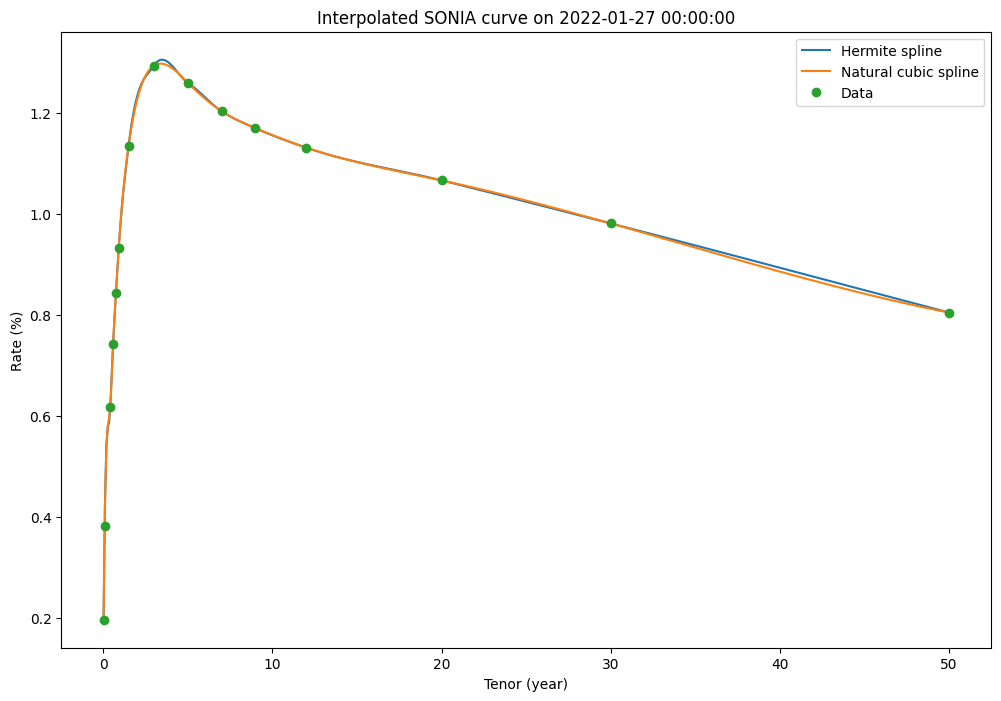

In [3]:
# convert tenors to numpy array in the unit of year
tenors = np.array([1/52, 2/52, 1/12, 2/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50])
# a dictionary that match column names to tenors
tenors_dict = dict(zip(df.columns, tenors))
# fit a hermite spline to first row with selected tenors
selected_tenors = df.columns[::2] # select some tenors not all to show that the curve is interpolated
x = np.array([tenors_dict[i] for i in selected_tenors])
date = df.index[0]
y = df.loc[date, selected_tenors].values
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)
# interpolate
xnew = np.arange(1/52,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
# plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date}')
plt.ylabel('Rate (%)')

## Interpolate with Financepy
- we will use swap rate that has integer year

In [4]:
%matplotlib widget
%matplotlib auto
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

Using matplotlib backend: module://ipympl.backend_nbagg


In [5]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.UNITED_KINGDOM
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for tenor in df.columns:
   if tenor[-1]=='Y': # only append yearly tenors for swap
      rate = df.loc[df.index[0], tenor]/100 # convert to %
      swap = IborSwap(effective_date=settlement_date, termination_date_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_coupon=rate, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
      swaps.append(swap)

Text(0.5, 1.0, 'Interpolated SONIA curve on 27-01-2022')

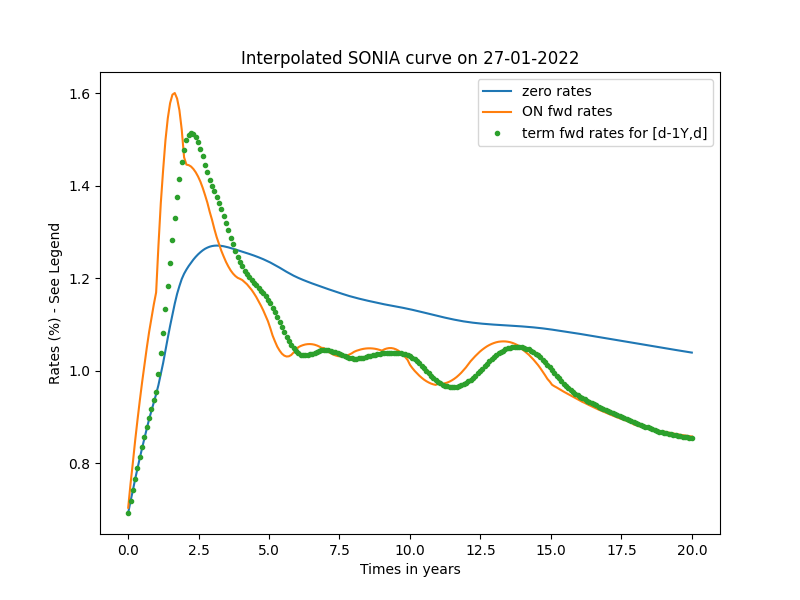

In [6]:
curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.PCHIP_LOG_DISCOUNT) # interpolate using PCHIP log discount
plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")}')

### Calibrate curve with swap for all available dates

In [7]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns] # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for date in tqdm(df.index, desc='Creating curves'): # loop through each date in the dataset
    swaps = []
    day, month, year = date.day, date.month, date.year
    valuation_date = Date(day, month, year) # convet to Date object
    spot_days = 0 # T+0
    settlement_date = valuation_date.add_weekdays(spot_days)
    for tenor in df.columns: # loop through each tenor in the dataset
        if tenor[-1]=='Y':
            rate = df.loc[date, tenor]/100
            swap = IborSwap(effective_date=settlement_date, termination_date_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_coupon=rate, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
            swaps.append(swap)

    curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.PCHIP_LOG_DISCOUNT)
    for year in year_columns:
        df_yield.loc[date, year] = curve.swap_rate(effective_date=valuation_date,maturity_date=valuation_date.add_years(year))
    curves[date] = curve # add this curve to the dictionary

Creating curves: 100%|██████████| 516/516 [02:55<00:00,  2.94it/s]


In [8]:
# store the curves dictionary and df_yield to a pickle file
with open('curves.pkl', 'wb') as f:
    pickle.dump(curves, f) # store the curves dictionary
df_yield.to_pickle('df_yield.pkl')